In [2]:
psd_segment_length = 4 # segment length for calculating the PSD by Welch's averaging 4

import lal as _lal
from pycbc.frame import read_frame
from pycbc.filter import highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.types.timeseries import load_timeseries
from pycbc.types.frequencyseries import load_frequencyseries
from pycbc.types.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.waveform import apply_fseries_time_shift
from pycbc.filter import sigma

%matplotlib notebook
import h5py
import json
import numpy as np
import readligo as rl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.signal import tukey
from scipy.interpolate import interp1d
from scipy.stats import skew, kurtosis
from numpy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [10]:
losc_unfilt = np.load('Results/H_STRAIN_LOSC_UNFILT_SEG_4.npy')
pycbc_filt = np.load('Results/H_STRAIN_PYCBC_FILT_SEG_4.npy')
pycbc_unfilt = np.load('Results/H_STRAIN_PYCBC_UNFILT_SEG_4.npy')

pycbc_str_filt = pycbc_filt[:,1]/np.sqrt(15./(4096./2.))
pycbc_str_unfilt = pycbc_unfilt[:,1]
t_pycbc = pycbc_filt[:,0]-pycbc_filt[:,0][0]

losc_str_unfilt = losc_unfilt[:,1]
t_losc = losc_unfilt[:,0]-losc_unfilt[:,0][0]

w = tukey(len(t_pycbc), alpha=0.4)

<IPython.core.display.Javascript object>


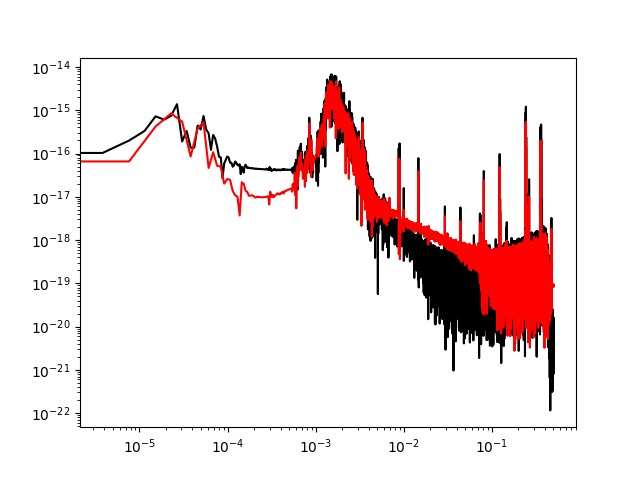

In [15]:
plt.figure(1)

pycbc_str_filt_w = w*pycbc_str_filt
pycbc_str_unfilt_w = w*pycbc_str_unfilt

ft_pycbc_filt = np.abs(rfft(pycbc_str_filt))
ft_pycbc_unfilt = np.abs(rfft(pycbc_str_unfilt))
ft_losc_unfilt = np.abs(rfft(losc_str_unfilt))
ft_losc_freq = rfftfreq(len(losc_str_unfilt))
ft_pycbc_freq = rfftfreq(len(pycbc_str_filt_w))

plt.loglog(ft_pycbc_freq,ft_pycbc_unfilt, c='k')
plt.loglog(ft_losc_freq, ft_losc_unfilt, c='r')
#plt.loglog(ft_pycbc_freq, ft_pycbc_filt, c='r')
#plt.xlim(0.001,0.04)